In [2]:
import tensorflow as tf
# from tensorflow.keras import models, layers => error version
from tensorflow import keras
from keras import models, layers
import matplotlib.pyplot as plt 

In [3]:
IMAGE_SIZE = 256
BATCH_SIZE = 32
CHANNELS = 3
EPOCHS= 30

In [4]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "PlantVillage",
    shuffle=True,
    image_size = (IMAGE_SIZE, IMAGE_SIZE),
    batch_size = BATCH_SIZE
)

Found 2152 files belonging to 3 classes.
Metal device set to: Apple M1 Pro

systemMemory: 16.00 GB
maxCacheSize: 5.33 GB



2023-01-21 10:42:22.596254: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-01-21 10:42:22.596750: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [5]:
dataset

<BatchDataset element_spec=(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

In [6]:
len(dataset)


68

In [7]:
class_names = dataset.class_names
class_names

['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']

In [8]:
len(dataset)

68

In [9]:
32*68

2176

In [10]:
dataset.take(1)

<TakeDataset element_spec=(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

2023-01-21 10:42:23.027014: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


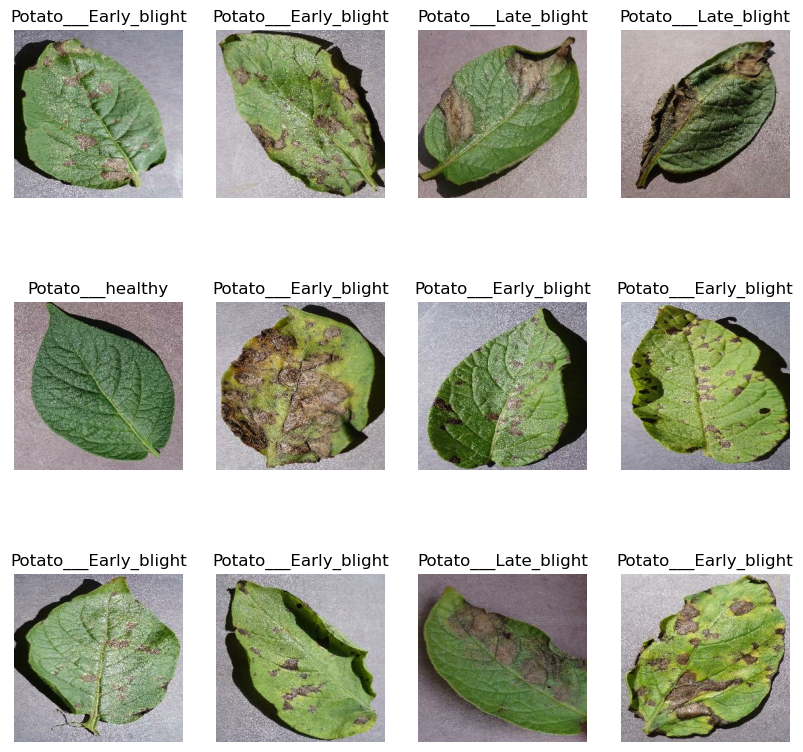

In [11]:
plt.figure(figsize=(10,10))
for image_batch, label_batch in dataset.take(1):
    for i in range(12):
        ax = plt.subplot(3,4 ,i+1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[label_batch[i]])
        plt.axis("off")

In [12]:
len(dataset)

68

In [13]:
# 80% ==> training
# 20% ==> 10% validation, 10% test

In [14]:
train_size = 0.8
len(dataset)*train_size

54.400000000000006

In [15]:
train_ds = dataset.take(54)
len(train_ds)

54

In [16]:
test_ds = dataset.skip(54)
len(test_ds)

14

In [17]:
val_size=0.1
len(dataset)*val_size

6.800000000000001

In [18]:
val_ds = test_ds.take(6)
len(val_ds)

6

In [19]:
test_ds = test_ds.skip(6)
len(test_ds)

8

In [20]:
def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1 , shuffle=True, shuffle_size=10000):
    
    ds_size = len(ds)
    
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)
    
    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)
    
    train_ds=ds.take(train_size)
    val_ds=ds.skip(train_size).take(val_size)
    test_ds=ds.skip(train_size).skip(val_size)
    
    return train_ds, val_ds, test_ds

In [21]:
train_ds, val_ds, test_ds =get_dataset_partitions_tf(dataset)

In [22]:
len(train_ds)

54

In [23]:
len(val_ds)

6

In [24]:
len(test_ds)

8

In [25]:
train_ds=train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds=val_ds.cache().prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds=test_ds.cache().prefetch(buffer_size=tf.data.AUTOTUNE)

In [26]:
resize_and_rescale =tf.keras.Sequential([
  keras.layers.experimental.preprocessing.Resizing(IMAGE_SIZE, IMAGE_SIZE),
  keras.layers.experimental.preprocessing.Rescaling(1.0/255)
])

In [27]:
data_augmentation = tf.keras.Sequential([
  keras.layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
  keras.layers.experimental.preprocessing.RandomRotation(0.2)
])

In [28]:
input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes = 3

model = models.Sequential([
  resize_and_rescale,
  data_augmentation,
  layers.Conv2D(32, (3,3) , activation='relu', input_shape = input_shape),
  layers.MaxPooling2D(2,2),
  layers.Conv2D(64, kernel_size= (3,3) , activation='relu'),
  layers.MaxPooling2D(2,2),
  layers.Conv2D(128, kernel_size= (3,3) , activation='relu'),
  layers.MaxPooling2D(2,2),
  layers.Conv2D(64, (3,3) , activation='relu'),
  layers.MaxPooling2D(2, 2),
  layers.Conv2D(64, (3,3) , activation='relu'),
  layers.MaxPooling2D(2, 2),
  layers.Conv2D(64, (3,3) , activation='relu'),
  layers.MaxPooling2D(2, 2),
  layers.Flatten(),
  layers.Dense(64, activation='relu'),
  layers.Dense(n_classes, activation='softmax')
])

model.build(input_shape=input_shape)

In [29]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (32, 256, 256, 3)         0         
                                                                 
 sequential_1 (Sequential)   (None, 256, 256, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 254, 254, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 127, 127, 32)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 125, 125, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 62, 62, 64)       0         
 2D)                                                  

In [30]:
model.compile(
  optimizer='adam',
  loss=tf.losses.SparseCategoricalCrossentropy(from_logits=False),
  metrics=['accuracy']
)

In [31]:
history=model.fit(
  train_ds,
  epochs=EPOCHS,
  batch_size = BATCH_SIZE,
  verbose=1,
  validation_data=val_ds
)

Epoch 1/30


2023-01-21 10:42:25.879539: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


54/54 [==============================] - ETA: 0s - loss: 0.8638 - accuracy: 0.5295

2023-01-21 10:42:53.865839: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


54/54 [==============================] - 31s 515ms/step - loss: 0.8638 - accuracy: 0.5295 - val_loss: 0.7671 - val_accuracy: 0.6042
Epoch 2/30
54/54 [==============================] - 31s 575ms/step - loss: 0.5258 - accuracy: 0.7691 - val_loss: 0.4106 - val_accuracy: 0.8125
Epoch 3/30
54/54 [==============================] - 31s 566ms/step - loss: 0.3268 - accuracy: 0.8692 - val_loss: 0.2714 - val_accuracy: 0.9010
Epoch 4/30
54/54 [==============================] - 30s 557ms/step - loss: 0.2571 - accuracy: 0.8981 - val_loss: 0.2007 - val_accuracy: 0.9219
Epoch 5/30
54/54 [==============================] - 31s 567ms/step - loss: 0.2094 - accuracy: 0.9196 - val_loss: 0.3456 - val_accuracy: 0.9062
Epoch 6/30
54/54 [==============================] - 31s 575ms/step - loss: 0.2059 - accuracy: 0.9167 - val_loss: 0.2656 - val_accuracy: 0.8854
Epoch 7/30
54/54 [==============================] - 30s 565ms/step - loss: 0.2191 - accuracy: 0.9120 - val_loss: 0.2669 - val_accuracy: 0.9010
Epoch 8/30

In [32]:
scores = model.evaluate(test_ds)

8/8 [==============================] - 1s 42ms/step - loss: 0.1901 - accuracy: 0.9492


In [33]:
scores

[0.19008047878742218, 0.94921875]

In [34]:
history

In [35]:
history.params

{'verbose': 1, 'epochs': 30, 'steps': 54}

In [ ]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [ ]:
history.history['accuracy']

[0.5017361044883728,
 0.6822916865348816,
 0.8460648059844971,
 0.875,
 0.9108796119689941,
 0.9184027910232544,
 0.9328703880310059,
 0.928819477558136,
 0.9473379850387573,
 0.9380787014961243,
 0.9589120149612427,
 0.960069477558136,
 0.9519675970077515,
 0.9664351940155029,
 0.9681712985038757,
 0.9565972089767456,
 0.9780092835426331,
 0.9629629850387573,
 0.9762731790542603,
 0.9791666865348816,
 0.9652777910232544,
 0.9745370149612427,
 0.9791666865348816,
 0.9803240895271301,
 0.9699074029922485,
 0.9855324029922485,
 0.9872685074806213,
 0.9878472089767456,
 0.9924768805503845,
 0.9855324029922485,
 0.9809027910232544,
 0.984375,
 0.984375,
 0.9814814925193787,
 0.9884259104728699,
 0.991319477558136,
 0.9907407760620117,
 0.9936342835426331,
 0.9953703880310059,
 0.9924768805503845,
 0.9890046119689941,
 0.9878472089767456,
 0.9855324029922485,
 0.9895833134651184,
 0.9918981790542603,
 0.9959490895271301,
 0.9814814925193787,
 0.9965277910232544,
 0.9918981790542603,
 0.9947

In [40]:
acc=history.history['accuracy']
val_acc=history.history['val_accuracy']

loss=history.history['loss']
val_loss=history.history['val_loss']

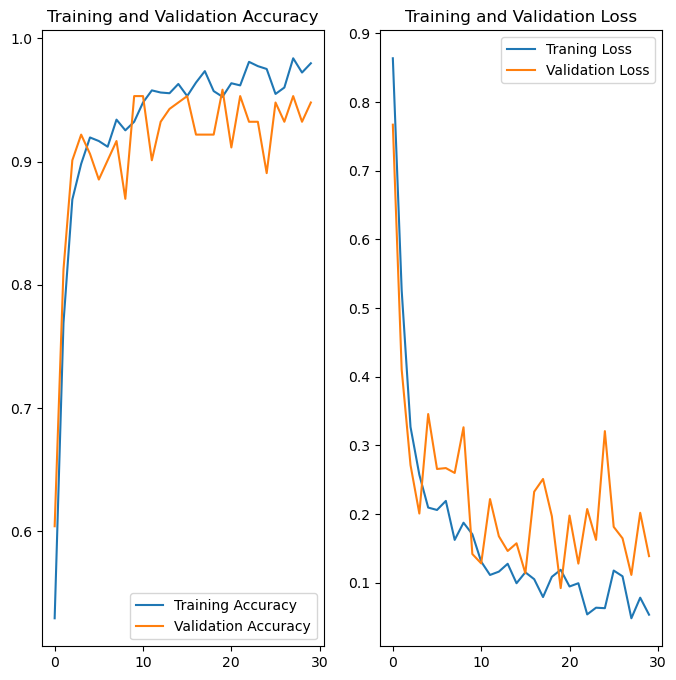

In [44]:
plt.figure(figsize=(8,8))
plt.subplot(1,2,1)
plt.plot(range(EPOCHS), acc ,label='Training Accuracy')
plt.plot(range(EPOCHS), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1,2,2)
plt.plot(range(EPOCHS), loss, label='Traning Loss')
plt.plot(range(EPOCHS), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

first image to predict
first image's actual label: Potato___Early_blight
1/1 [==============================] - 0s 28ms/step
predicted label: Potato___Late_blight


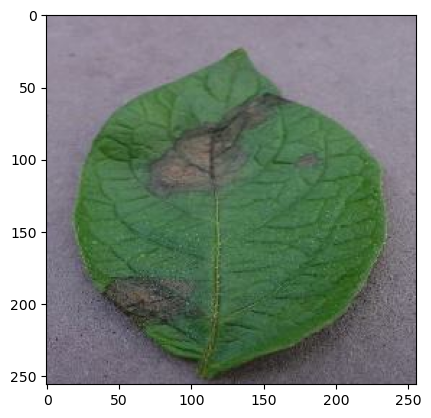

In [65]:
import numpy as np

for images_batch, labels_batch in test_ds.take(1):
  first_image =images_batch[0].numpy().astype('uint8')
  first_label = label_batch[0].numpy()


  print("first image to predict")
  plt.imshow(first_image)
  print("first image's actual label:", class_names[first_label])

  batch_prediction =model.predict(images_batch)
  print("predicted label:",class_names[np.argmax(batch_prediction[0])])

In [82]:
def predict(model, img):
  img_array = tf.keras.preprocessing.image.img_to_array(img)
  img_array=tf.expand_dims(img_array,0) # create a batch

  predictions = model.predict(img_array)

  predicted_class = class_names[np.argmax(predictions[0])]
  confidence = round(100 * (np.max(predictions[0])),2)

  return predicted_class, confidence

1/1 [==============================] - 0s 22ms/step


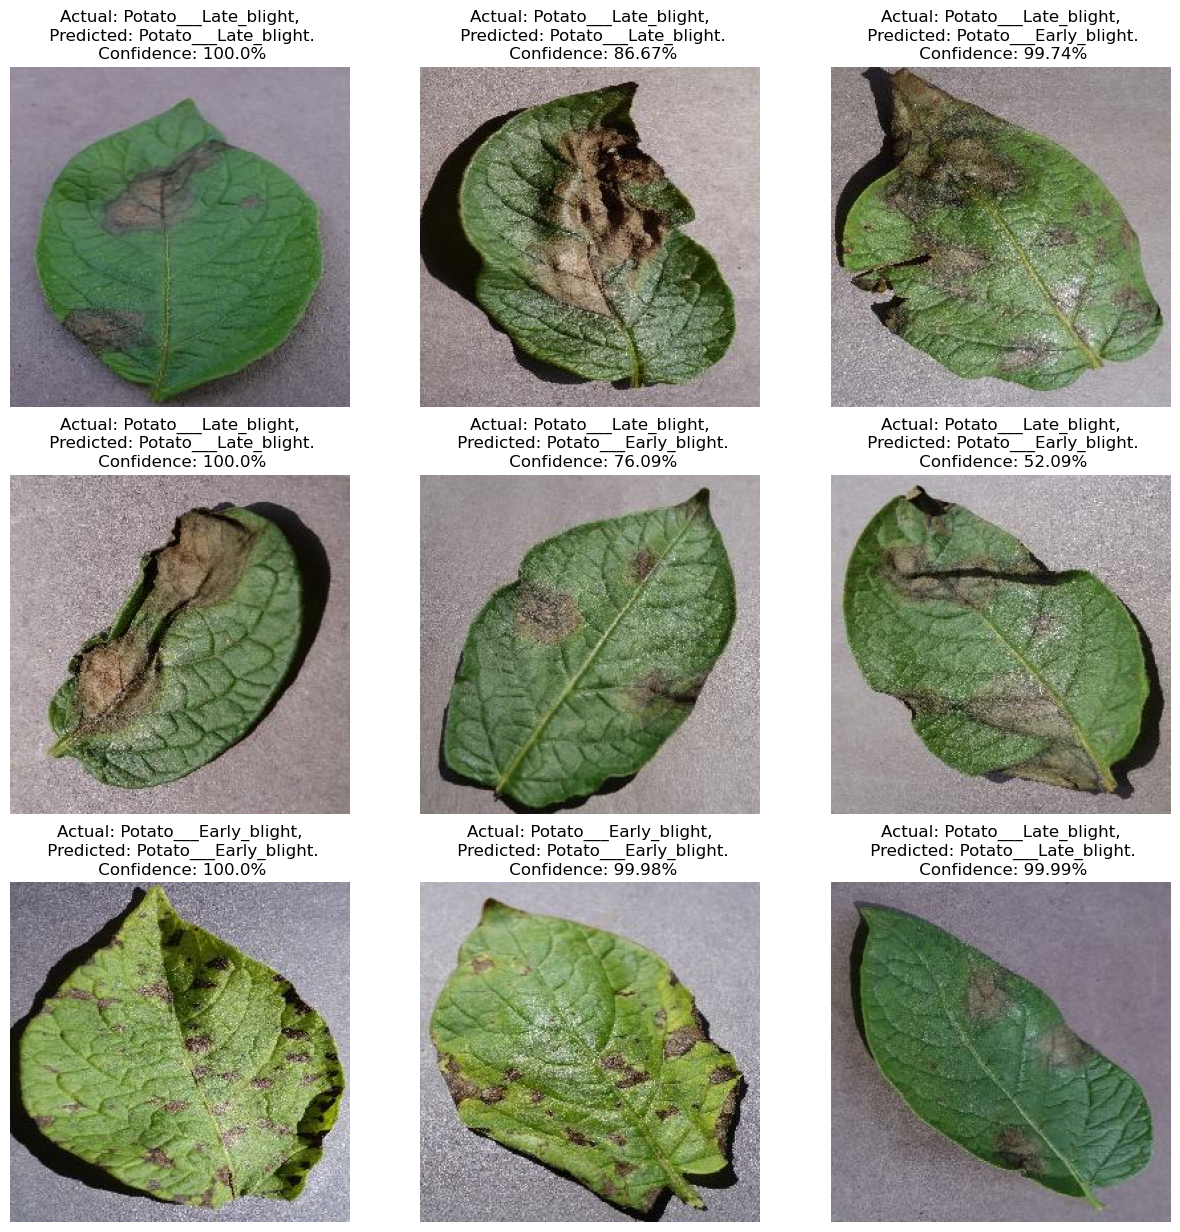

In [85]:
plt.figure(figsize=(15, 15))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))

        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]]

        plt.title(
            f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")

        plt.axis("off")


In [87]:
model_version=2
model.save(f"../models/{model_version}")

INFO:tensorflow:Assets written to: ../models/2/assets


INFO:tensorflow:Assets written to: ../models/2/assets


In [90]:
import os 
recent_model=max([int(i) for i in os.listdir("../models")])
recent_model

2

In [91]:
model.score()

AttributeError: 'Sequential' object has no attribute 'score'